# How to build the dataset of recipes.

In the following we get the recipes from [giallozafferano.it](https://www.giallozafferano.it/), but a similar technique can be applied to any dataset of recipes

This work is based on Park, D., Kim, K., Kim, S. et al. FlavorGraph: a large-scale food-chemical graph for generating food representations and recommending food pairings. Sci Rep 11, 931 (2021). https://doi.org/10.1038/s41598-020-79422-8 

In [ ]:
# -*- coding: utf-8 -*-
import requests
from bs4 import BeautifulSoup
import re
import json


def get_max_pages_each():
    global url
    global pages
    max_pages_each = list()
    for i in range(len(pages)):
        print(url+'/'+pages[i])
        response = requests.get(url+'/'+pages[i])
        print(response)
        soup = BeautifulSoup(response.text, "html.parser")
        num = soup.find('span', class_='disabled total-pages')
        max_pages_each.append(int(num.text))
    return max_pages_each


url = 'https://giallozafferano.it/ricette-cat'
pages = ['Antipasti', 'Primi', 'Secondi-piatti',
         'Contorni', 'Dolci-e-Desserts', 'Lievitati', 'Piatti-Unici']
max_pages_each = get_max_pages_each()

with open('gz_links.json', mode='w', encoding='utf-8') as fp:
    Rlinks = list()
    for i in range(len(pages)):
        for j in range(max_pages_each[i]):
            # https://www.giallozafferano.it/ricette-cat/page2/Antipasti/
            page_url = url+'/page'+str(j+1)+'/'+pages[i]
            print(f'Getting: {page_url}')
            response = requests.get(page_url)
            soup = BeautifulSoup(response.text, "html.parser")

            links = soup.find_all('h2', class_='gz-title')
            for x in range(len(links)):
                links[x] = links[x].a['href']
            Rlinks += links
    
    Rlinks = list(dict.fromkeys(Rlinks)) # Remove possible duplicate links
    fp.write(json.dumps(Rlinks, indent=4, sort_keys=False))
    print('Done collecting links')

At the end you will have the file gz_links.json with a list of URLs pointing to the recipes

```json
[
    "https://ricette.giallozafferano.it/Hummus.html",
    "https://ricette.giallozafferano.it/Focaccia-fugassa-alla-genovese.html",
    ...
]
```

In [ ]:
# -*- coding: utf-8 -*-
import urllib3
from bs4 import BeautifulSoup
import re
import json
import codecs
import lxml


class Recipe():
    def __init__(self, url):
        self.url = url

    def get(self):
        url = self.url
        http = urllib3.PoolManager()
        urllib3.disable_warnings()
        response = http.request('GET', url)
        html = codecs.decode(response.data, 'utf-8')
        soup = BeautifulSoup(html, "html.parser")

        # Title
        Rtitle = soup.find('h1', class_='gz-title-recipe').text

        # Ingredients
        ingredients = soup.find_all('dd', class_='gz-ingredient')
        Ringredients = list(dict())
        for i in range(len(ingredients)):
            Ringredients.append({'ingredient': ingredients[i].a.text, 'quantity': " ".join(
                ingredients[i].span.text.split())})

        # Preparation
        for i in soup.find_all(class_='num-step'):
            i.string = ''
        Rpreparation = ""
        preparation = soup.find_all('div', class_='gz-content-recipe-step')
        for i in range(len(preparation)):
            Rpreparation += preparation[i].text
        Rpreparation = re.sub('\s+', ' ', Rpreparation)
        
        Recipe = {'title': Rtitle, 'ingredients': Ringredients,
                  'preparation': Rpreparation}
        return Recipe

In [ ]:
# -*- coding: utf-8 -*-
from get_recipes import Recipe
import json
import sys


def delete_last_line():
    sys.stdout.write('\x1b[1A')
    sys.stdout.write('\x1b[2K')


links = json.loads(open('gz_links.json', mode='r', encoding='utf-8').read())
n_links = len(links)
for i in range(n_links):
        delete_last_line()
        print(f'Getting {i} of {n_links} - {round(i/n_links*100,2)}% done.')
        filename = f'gzd{str(i)}.json'
        with open(filename, mode='w', encoding='utf-8') as fp:
                R = Recipe(links[i]).get()
                json.dump(R, fp, indent=4, sort_keys=False, ensure_ascii=False)
print(f'Done getting all {n_links} recipes.')

Now you have all the recipes stored in json files like the following one (i.e. gzd6083.json)

```json
{
    "title": "Burrata con verdura e frutta grigliate",
    "ingredients": [
        {
            "ingredient": "Burrata",
            "quantity": "(4 da 125 g l'una) 500 g"
        },
        {
            "ingredient": "Radicchio",
            "quantity": "lungo 540 g"
        },
        {
            "ingredient": "Indivia belga",
            "quantity": "500 g"
        },
        {
            "ingredient": "Spinacini",
            "quantity": "60 g"
        },
        {
            "ingredient": "Cachi mela",
            "quantity": "600 g"
        },
        {
            "ingredient": "Mele Golden",
            "quantity": "500 g"
        },
        {
            "ingredient": "Olio extravergine d'oliva",
            "quantity": "100 g"
        },
        {
            "ingredient": "Basilico",
            "quantity": "5 foglie"
        },
        {
            "ingredient": "Timo",
            "quantity": "4 rametti"
        },
        {
            "ingredient": "Sale fino",
            "quantity": "q.b."
        },
        {
            "ingredient": "Pepe nero",
            "quantity": "q.b."
        }
    ],
    "preparation": " Per realizzare la burrata con verdura e frutta grigliate per prima cosa preparate gli ingredienti: eliminate la base del cespo di radicchio e dividetelo per il lungo in 4 spicchi . Fate la stessa cosa con l’indivia belga . Tagliate il caco mela prima a metà e poi in spicchi, dopodiché dividete ogni spicchio ancora a metà . Fate la stessa anche con la mela, senza rimuovere la buccia . Adagiate la frutta su una griglia ben calda e grigliatela su entrambi i lati per un totale di 3-4 minuti . Grigliate anche l’indivia belga e il radicchio . Tenete da parte la frutta e la verdura grigliate e passate al condimento: versate il basilico e il timo in un boccale , poi aggiungete l’olio . Salate , pepate e frullate con un mixer a immersione fino ad ottenere una consistenza omogenea . Componete i piatti adagiando un letto di foglie di spinacino, lavate e asciugate, poi aggiungete la verdura e frutta grigliata e posizionate al centro una burrata . Condite con l’olio aromatizzato e servite la vostra burrata con verdura e frutta grigliate ! "
}
```

# Build the graphs of recipes

We build a graph in which nodes are the ingredients and there is an edge connecting two nodes (i.e. ingredients) if they both appear in at least a recipe. The weight of an edge shows the number of recipes in which the two ingredients appear together

In [ ]:
import json
import networkx as nx
from itertools import combinations

G=nx.Graph()

links = json.loads(open('data/gz_links.json', mode='r', encoding='utf-8').read())
n_links = len(links)
for i in range(n_links):
#for i in range(0,1):
    filename = f'data/gzd{str(i)}.json'
    with open(filename, mode='r', encoding='utf-8') as fp:
        data = json.load(fp)
        l = []
        for i in data['ingredients']:
            l.append(i['ingredient'])
        l  = list( dict.fromkeys(l) )
        all_edges = list(combinations(l, 2))
        #G.add_edges_from(all_edges)
        
        for e in all_edges:
            if (G.has_edge(e[0],e[1])):
                w = G.edges[e[0],e[1]]['weight']
                G.add_edge(e[0],e[1], weight=w+1)
            else:
                G.add_edge(e[0],e[1], weight=1)
            
            
    

In [ ]:
print(nx.number_of_nodes(G), nx.number_of_edges(G))

In [ ]:
# show all the Vertexes in the graphs, namely the ingredients
list(G.nodes)

In [ ]:
# show all the deges in the graph
G.edges

In [ ]:
G.edges['Gelato al cioccolato', 'Gelato alla panna']['weight']

In [ ]:
# write the Graph into a file 

nx.write_gexf(G, "gz_graph_weighted.gexf")

# Visualize the graph

In [7]:
# load the graph of the ingredients

import networkx as nx
G = nx.read_gexf("data/gz_graph_weighted.gexf")

In [11]:
for n in G.neighbors('Pecorino romano'):
    print(n)


Succo di limone
Aglio
Olio extravergine d'oliva
Acqua
Sale fino
Paprika dolce
Prezzemolo
Pepe nero
Farina 00
Farina Manitoba
Lievito di birra fresco
Sale
Cavolo cappuccio
Cipollotto fresco
Salsa di soia
Pepe bianco
Avocado
Cipolle bianche
Pomodori ramati
Ricotta vaccina
Capperi sotto sale
Pangrattato
Uova
Parmigiano Reggiano DOP
Olio di semi di arachide
Burro
Cipolle
Passata di pomodoro
Pisellini
Vino rosso
Mozzarella
Olio di semi
Carote
Zucchero
Origano
Pane bianco in cassetta
Olio di semi di girasole
Sedano
Cipolle dorate
Vino bianco
Pepe nero in grani
Acciughe sott'olio
Brodo di carne
Edamer
Robiola
Basilico
Tuorli
Latte intero
Pane
Scorza di limone
Timo
Maggiorana
Scamorza affumicata
Salvia
Melanzane
Patate
Aceto di vino bianco
Zucca delica
Panna fresca liquida
Strutto
Grana Padano DOP
Farina 0
Noce moscata
Pinoli
Pecorino
Lievito istantaneo per preparazioni salate
Scamorza (provola)
Pomodori secchi sott'olio
Rosmarino
Sale grosso
Zucchine
Porri
Speck
Salame napoletano
Vino bianco 

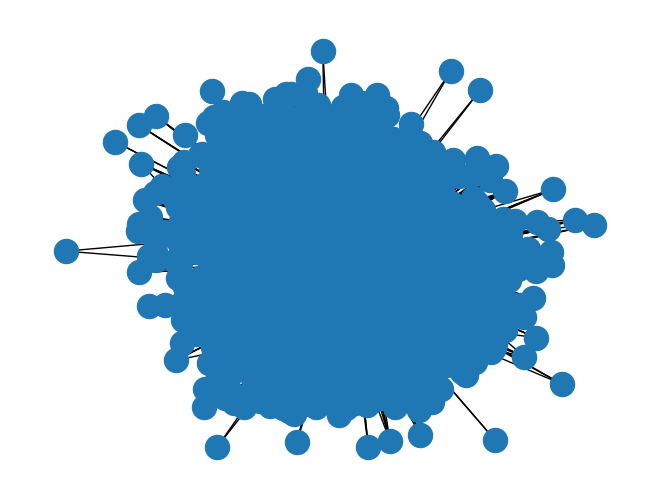

In [20]:
nx.draw(G)

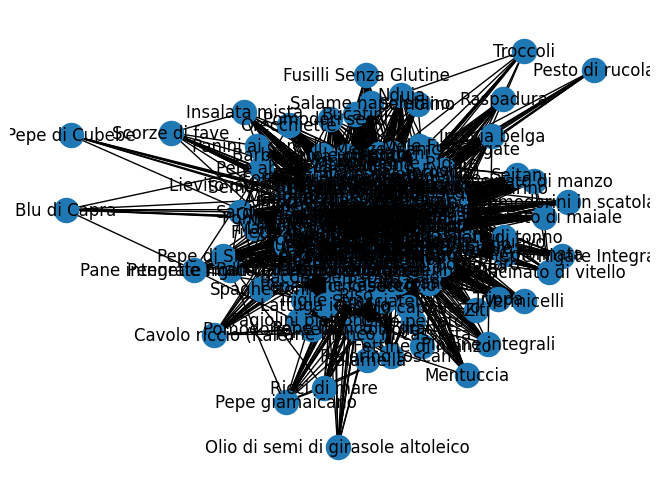

In [24]:
nx.draw(G.subgraph(G.neighbors('Pecorino romano')), with_labels = True)

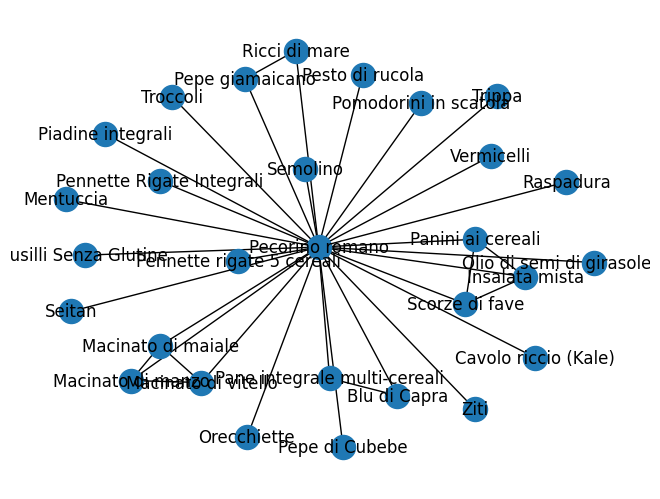

In [41]:
def filter_node(n1):
    if n1 == 'Pecorino romano':
        return n1
    if n1 in G.neighbors('Pecorino romano') and G.degree[n1] < 45:
        return n1
view = nx.subgraph_view(G, filter_node=filter_node)
nx.draw(view, with_labels = True)

# Build the embedding

In [1]:
# load the graph of the ingredients

import networkx as nx
G = nx.read_gexf("data/gz_graph_weighted.gexf")

In [6]:
G.nodes

NodeView(('Ceci precotti', 'Succo di limone', 'Tahina', 'Aglio', "Olio extravergine d'oliva", 'Acqua', 'Sale fino', 'Paprika dolce', 'Prezzemolo', 'Pepe nero', 'Semi di sesamo', 'Olio di sesamo', 'Farina 00', 'Farina Manitoba', 'Malto', 'Lievito di birra fresco', 'Sale', 'Maiale', 'Cavolo cappuccio', 'Cipollotto fresco', 'Vino di riso', 'Salsa di soia', 'Pepe bianco', 'Avocado', 'Cipolle bianche', 'Succo di lime', 'Coriandolo', 'Pomodori ramati', "Tonno sott'olio", 'Ricotta vaccina', 'Acciughe (alici)', 'Capperi sotto sale', 'Pangrattato', 'Uova', 'Parmigiano Reggiano DOP', 'Olio di semi di arachide', 'Zafferano', 'Burro', 'Riso vialone nano', 'Caciocavallo', 'Cipolle', 'Passata di pomodoro', 'Pisellini', 'Vino rosso', 'Prosciutto cotto', 'Mozzarella', 'Olio di semi', 'Sfoglie per involtini', 'Carote', 'Albumi', 'Zucchero', 'Fiordilatte', 'Origano', 'Pane bianco in cassetta', 'Mozzarella di bufala', 'Olio di semi di girasole', 'Vitello', 'Sedano', 'Cipolle dorate', 'Vino bianco', 'Allo

In [14]:
print(G.get_edge_data('Pecorino romano','Guanciale'))
print(G.get_edge_data('Pecorino romano','Scorze di fave'))

{'id': '39695', 'weight': 9.0}
{'id': '39774', 'weight': 1.0}


In [32]:
import pandas as pd
data = []
for u,v,a in G.edges(data=True):
    data.append([u,v,int(a['weight'])])
df = pd.DataFrame(data, columns=['node1', 'node2', 'weight']) 

In [33]:
df.sort_values('weight', ascending=False)

,node1,node2,weight
1735,Olio extravergine d'oliva,Sale fino,2754
4032,Sale fino,Pepe nero,2350
1738,Olio extravergine d'oliva,Pepe nero,1962
4035,Sale fino,Farina 00,1455
4056,Sale fino,Uova,1362
...,...,...,...
29471,Salvia,Triglie,1
29472,Salvia,Pesce del prete,1
29473,Salvia,Scorfano,1
29474,Salvia,Tracina,1


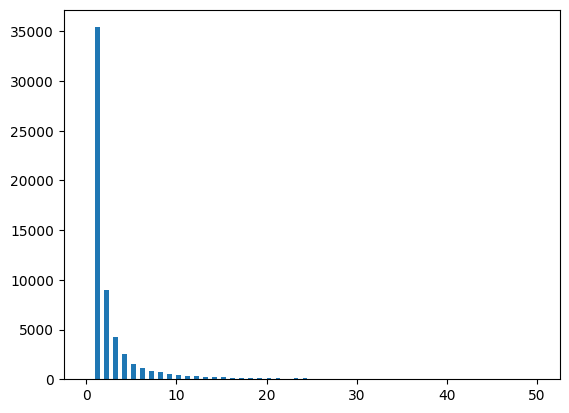

In [37]:
from matplotlib import pyplot as plt

plt.hist(list(df['weight']),bins=100,range=[0, 50])

plt.show()

In [2]:
#https://github.com/eliorc/node2vec
from node2vec import Node2Vec

In [3]:
#node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
node2vec_weighted = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4, weight_key ='weight')

Computing transition probabilities:   0%|          | 0/1675 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [09:21<00:00, 11.23s/it]


In [4]:
#model = node2vec.fit(window=10, min_count=1, batch_words=4)
model_weighted = node2vec_weighted.fit(window=10, min_count=1, batch_words=4)

In [ ]:
import pickle 

# store the embedding

with open('data/emedding_model.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [5]:
import pickle 

# store the embedding

with open('data/emedding_model_weighted.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(model_weighted, f, pickle.HIGHEST_PROTOCOL)

# Work with the embedding

In [38]:
import pickle

with open('data/emedding_model_weighted.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    model1 = pickle.load(f)

In [39]:
print(model1.wv.key_to_index)

{'Sale fino': 0, "Olio extravergine d'oliva": 1, 'Pepe nero': 2, 'Farina 00': 3, 'Uova': 4, 'Burro': 5, 'Acqua': 6, 'Zucchero': 7, 'Aglio': 8, 'Latte intero': 9, 'Panna fresca liquida': 10, 'Zucchero a velo': 11, 'Timo': 12, 'Tuorli': 13, 'Prezzemolo': 14, 'Scorza di limone': 15, 'Carote': 16, 'Rosmarino': 17, 'Lievito in polvere per dolci': 18, 'Parmigiano Reggiano DOP': 19, 'Grana Padano DOP': 20, 'Basilico': 21, 'Baccello di vaniglia': 22, 'Patate': 23, 'Vino bianco': 24, 'Sedano': 25, 'Noce moscata': 26, 'Pangrattato': 27, 'Succo di limone': 28, 'Brodo vegetale': 29, 'Zucchine': 30, 'Cioccolato fondente': 31, 'Zucchero di canna': 32, 'Menta': 33, 'Passata di pomodoro': 34, 'Scalogno': 35, 'Salvia': 36, 'Cipolle': 37, 'Amido di mais (maizena)': 38, 'Peperoncino fresco': 39, 'Cacao amaro in polvere': 40, 'Ricotta vaccina': 41, 'Pomodorini ciliegino': 42, 'Alloro': 43, 'Cipolle bianche': 44, 'Origano': 45, 'Olio di semi': 46, 'Olio di semi di arachide': 47, 'Albumi': 48, 'Erba cipolli

In [ ]:
print(model1.wv.index_to_key)

In [41]:
# find all ingredients containig a specific string

reference = "Pecorino"

matching = [s for s in model1.wv.index_to_key if reference in s]

In [42]:
matching

['Pecorino',
 'Pecorino romano',
 'Pecorino sardo',
 'Pecorino toscano',
 'Pecorino di fossa']

In [43]:
# To get the vector associated to a specific ingredient

test_ingredient = 'Pecorino romano'
model1.wv.get_vector(test_ingredient)

array([ 3.7565199e-01, -3.3088776e-01, -2.1588257e-01, -6.8100169e-02,
       -7.9298258e-02, -1.9266851e-01,  1.1190128e-01, -6.4294949e-02,
        8.1699602e-03,  3.9889749e-02,  2.4745989e-01,  6.9841869e-02,
       -2.7777350e-01, -1.0348910e-01, -1.0276256e-01,  9.3753281e-04,
       -4.9879145e-02,  3.0255772e-02, -9.9259848e-04, -9.9410526e-02,
       -1.6045690e-01,  1.3735431e-01,  1.5602282e-01,  3.7056409e-02,
        2.0753638e-01,  1.9011991e-01,  3.3928189e-02,  4.6311918e-01,
        1.4735436e-01, -2.6564956e-01,  7.7746801e-02, -2.1241546e-01,
       -3.7303235e-02,  8.9528739e-02, -6.4674646e-02, -2.0097357e-01,
       -2.0582320e-02,  5.0508592e-02, -5.9287753e-02,  2.6296392e-01,
       -1.4370000e-01,  7.9216182e-02,  6.1521303e-02, -2.1699210e-01,
       -1.4607301e-01, -5.3681150e-02,  2.1876234e-03, -2.3576880e-01,
        1.1256024e-01, -9.5819552e-05,  6.3921951e-02, -3.0988932e-02,
       -1.3206023e-01,  7.3812366e-02, -1.6448115e-01, -1.7129692e-01,
      

In [44]:
# To get the most similar ingredients

model1.wv.most_similar(test_ingredient,  topn=20)

[('Guanciale', 0.697201669216156),
 ('Pepe di Cubebe', 0.6447087526321411),
 ('Fave', 0.6323457956314087),
 ('Ricci di mare', 0.6197477579116821),
 ('Scorze di fave', 0.6176154017448425),
 ('Spaghetti', 0.6120122671127319),
 ('Parmigiano Reggiano DOP', 0.6106644868850708),
 ("Olio extravergine d'oliva", 0.5842905044555664),
 ('Pesto di rucola', 0.5800992250442505),
 ('Sale fino', 0.5687153935432434),
 ('Pecorino toscano', 0.5633164048194885),
 ('Pepe nero', 0.5603302121162415),
 ("Tagliatelle all'uovo", 0.555862545967102),
 ('Aglio', 0.5525346398353577),
 ('Pecorino', 0.547160267829895),
 ('Blu di Capra', 0.5468024611473083),
 ('Pennette rigate 5 cereali', 0.5463517904281616),
 ('Ziti', 0.5422918200492859),
 ('Pomodori pelati', 0.5410119295120239),
 ('Rigatoni', 0.5373810529708862)]

In [10]:
model1.wv.similarity(test_ingredient, 'Guanciale')

0.78957117

In [11]:
# Save embeddings for later use
model1.wv.save_word2vec_format('data/embedding')

# Save model for later use
model1.save('data/model')

# Playground to test similarity of given ingredients

In [12]:
reference = "Miele"
matching = [s for s in model1.wv.index_to_key if reference in s]

In [13]:
matching

['Miele',
 'Miele millefiori',
 'Miele di acacia',
 'Miele di castagno',
 'Miele di tiglio',
 'Miele di arancio',
 'Miele di timo',
 'Miele di erica',
 'Miele di corbezzolo']

In [14]:
for ing in matching:
    print(test_ingredient,ing,model1.wv.similarity(test_ingredient, ing))

Pecorino romano Miele 0.2783068
Pecorino romano Miele millefiori 0.27757794
Pecorino romano Miele di acacia 0.2922621
Pecorino romano Miele di castagno 0.0755361
Pecorino romano Miele di tiglio 0.25341237
Pecorino romano Miele di arancio 0.22182617
Pecorino romano Miele di timo 0.12730217
Pecorino romano Miele di erica 0.10013109
Pecorino romano Miele di corbezzolo 0.08201472


In [ ]:
reference = "Prosciutto"
matching = [s for s in model1.wv.index_to_key if reference in s]
for ing in matching:
    print(test_ingredient,ing,model1.wv.similarity(test_ingredient, ing))

In [ ]:
reference = "Olive"
matching = [s for s in model1.wv.index_to_key if reference in s]
for ing in matching:
    print(test_ingredient,ing,model1.wv.similarity(test_ingredient, ing))

In [ ]:
reference = "Pomodori"
matching = [s for s in model1.wv.index_to_key if reference in s]
for ing in matching:
    print(test_ingredient,ing,model1.wv.similarity(test_ingredient, ing))

In [ ]:
reference = "Pane"
matching = [s for s in model1.wv.index_to_key if reference in s]
for ing in matching:
    print(test_ingredient,ing,model1.wv.similarity(test_ingredient, ing))

In [ ]:
reference = "Noci"
matching = [s for s in model1.wv.index_to_key if reference in s]
for ing in matching:
    print(test_ingredient,ing,model1.wv.similarity(test_ingredient, ing))

# Double Check

Measuring explictily the distance among vecors (i.e. ingredients) in the graph

In [1]:
import networkx as nx
G = nx.read_gexf("data/gz_graph_weighted.gexf")

In [ ]:
from scipy.spatial import distance

distances ={}

for ingred in G.nodes:
        distances[ingred]=distance.cosine(model1.wv.get_vector(test_ingredient), model1.wv.get_vector(ingred))


In [ ]:
distances

In [ ]:
sort_dictionary= dict(sorted(distances.items(), key=lambda item: item[1])) 
print("Sorted Dictionary by value: ", sort_dictionary)

In [ ]:
from itertools import islice
 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n=50
n_items = take(n, sort_dictionary.items())

print(n_items)

# Make a nice plot

In [20]:
import pandas as pd
df3 = pd.DataFrame.from_dict(model1.wv.most_similar(test_ingredient,  topn=40))
df3.columns = ['Name', 'Value']

In [21]:
df3

,Name,Value
0,Guanciale,0.789571
1,Fave,0.624284
2,Pennette rigate 5 cereali,0.613964
3,Rigatoni,0.613742
4,Parmigiano Reggiano DOP,0.593906
5,Spaghetti,0.590675
6,Scorze di fave,0.579697
7,Pepe di Cubebe,0.578230
8,Olio di semi di girasole altoleico,0.575322
9,Troccoli,0.574311


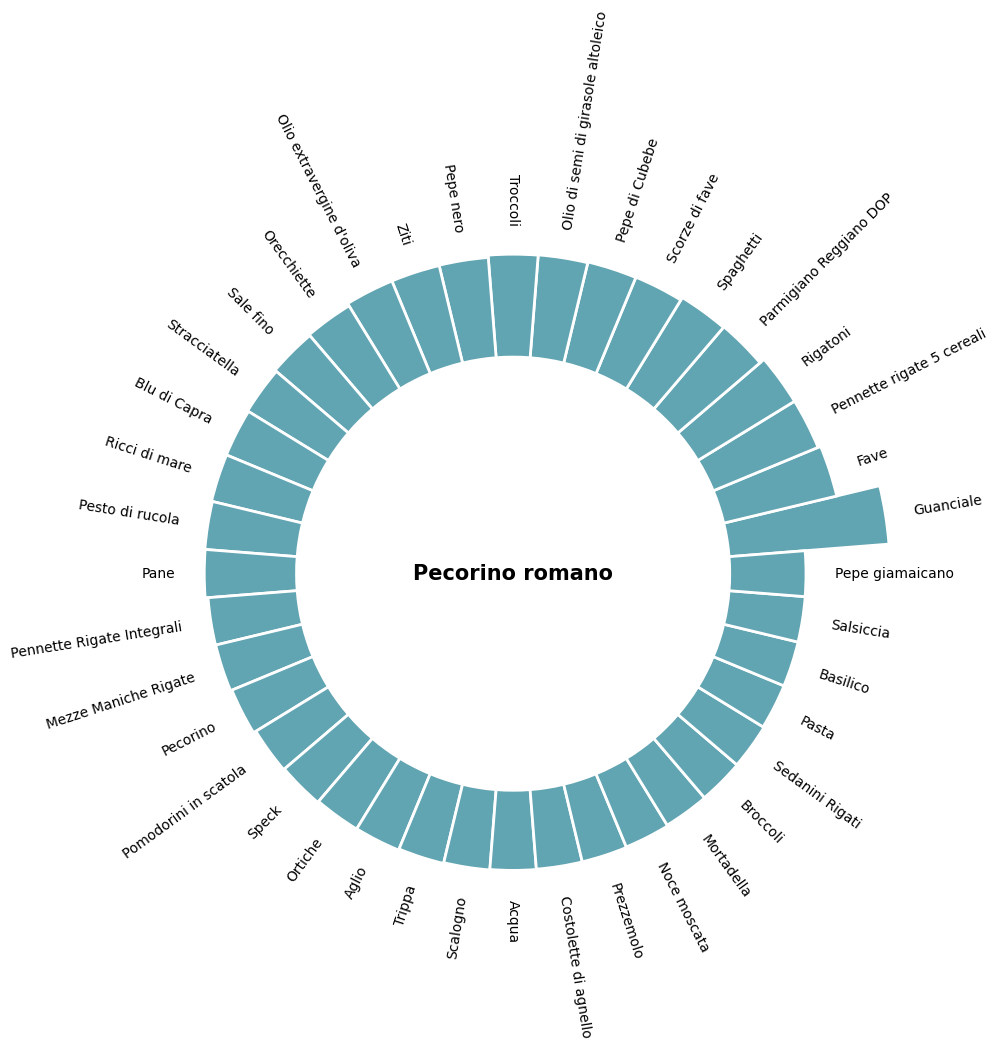

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 30
labelPadding = 4

# Compute max and min in the dataset
max = df3['Value'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max

# note 1-df3.Value
heights = slope * (1-df3.Value) + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df3.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df3.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)

# little space between the bar and the label
labelPadding = 4

#polar coo 0,0 is the center
plt.text(0,0,test_ingredient,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},fontsize=15,fontweight='bold',
          ha='center', va='center') 

# Add labels
for bar, angle, height, label in zip(bars, angles, heights, df3["Name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 
    
plt.savefig('filename.png', format='png', transparent=True)

# Nice Plot with only six ingredients

These ingredients can be easily conserved and are thus good candidates for the game 

In [27]:
import pandas as pd
pairings = ['Miele di acacia','Prosciutto crudo','Olive di Gaeta','Pomodori secchi','Pane','Noci']

d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)

measure = []
for p in pairings:
    measure.append(model1.wv.similarity(test_ingredient, p))
    
df4 = pd.DataFrame(data = {'Name':pairings, 'Value':measure})

In [35]:
df4.sort_values('Value')

,Name,Value
5,Noci,0.244200
0,Miele di acacia,0.292262
2,Olive di Gaeta,0.320085
3,Pomodori secchi,0.325147
1,Prosciutto crudo,0.397396
4,Pane,0.534565


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 30
labelPadding = 4

# Compute max and min in the dataset
max = df4['Value'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max

# note 1-df3.Value
heights = slope * (1-df4.Value) + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df4.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df4.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)

# little space between the bar and the label
labelPadding = 4

#polar coo 0,0 is the center
plt.text(0,0,test_ingredient,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},fontsize=15,fontweight='bold',
          ha='center', va='center') 

# Add labels
for bar, angle, height, label in zip(bars, angles, heights, df4["Name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 
    
plt.savefig('filename.png', format='png', transparent=True)

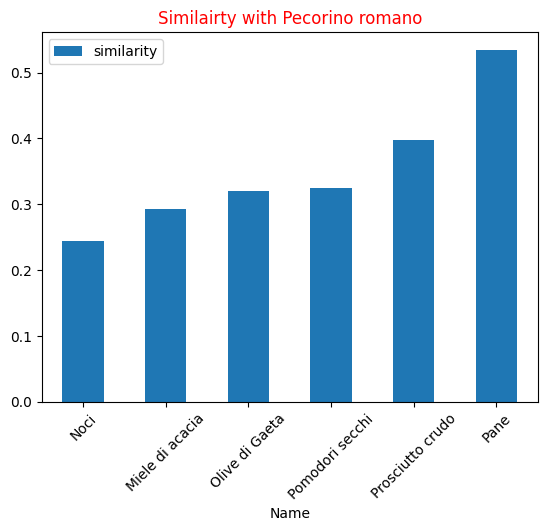

In [53]:
df4.sort_values('Value').plot.bar(x='Name', y='Value', rot=45, legend=None)
plt.title("Similairty with "+test_ingredient, color = 'red')
plt.legend(["similarity"])

Compare results iwth chtaGPT suggestions

![](assets/images/2023-08-30-14-39-01.png)